### Geo data
The column for federal entities' abbreviation is transformed to match the column "ENTIDAD_UM" in the COVID-19 data frame . 

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

from sklearn import preprocessing

sns.set()
%matplotlib inline

In [62]:
path = "Data/"
#covid_general = file_folder(path)

In [75]:
df_geo_states = gpd.read_file(path + "mexstates.shp")

In [76]:
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].str.replace("MX0","")
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].str.replace("MX","")
df_geo_states['FIPS_ADMIN'] = df_geo_states['FIPS_ADMIN'].astype(int)

In [77]:
df_geo_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    32 non-null     int64   
 1   FIPS_ADMIN  32 non-null     int64   
 2   GMI_ADMIN   32 non-null     object  
 3   ADMIN_NAME  32 non-null     object  
 4   FIPS_CNTRY  32 non-null     object  
 5   GMI_CNTRY   32 non-null     object  
 6   CNTRY_NAME  32 non-null     object  
 7   POP_ADMIN   32 non-null     int64   
 8   TYPE_ENG    32 non-null     object  
 9   TYPE_LOC    32 non-null     object  
 10  SQKM        32 non-null     float64 
 11  SQMI        32 non-null     float64 
 12  COLOR_MAP   32 non-null     object  
 13  Shape_Leng  32 non-null     float64 
 14  Shape_Area  32 non-null     float64 
 15  geometry    32 non-null     geometry
dtypes: float64(4), geometry(1), int64(3), object(8)
memory usage: 4.1+ KB


In [53]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"clean_data.csv", encoding='latin-1')
df_general = df_genera_mx

In [54]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
0,2020-08-02,081a96,2,ESTATAL,27,Men,10,AMBULATORIO,2020-06-18,2020-06-16,...,1,99,0,TC,0,0,0,2,3,0
1,2020-08-02,0a1ae8,2,IMSS,9,Men,2,AMBULATORIO,2020-04-20,2020-04-17,...,1,99,0,DF,0,0,0,3,0,0
2,2020-08-02,1d77f8,2,IMSS,15,Men,39,HOSPITALIZADO,2020-04-22,2020-04-20,...,1,99,0,MC,0,0,0,2,2,0
3,2020-08-02,143e18,2,ESTATAL,25,Men,6,HOSPITALIZADO,2020-04-15,2020-04-08,...,1,99,0,SL,0,0,0,7,2,0
4,2020-08-02,0f69b4,2,ESTATAL,15,Men,106,AMBULATORIO,2020-05-27,2020-05-25,...,1,99,0,MC,0,0,0,2,2,0


In [55]:
df_positive = df_general[ df_general['RESULTADO'] == 1]

In [59]:
df_cumulative = df_positive.groupby(['FECHA_SINTOMAS', 'ENTIDAD_UM'])['RESULTADO', 'DEF'].sum()

/Users/erika/Documents/COVID/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [60]:
df_cumulative
df_cumulative = df_cumulative.reset_index()
df_cumulative.rename({1: 'FECHA'}, axis=1, inplace=True)

In [61]:
df_cumulative

,FECHA_SINTOMAS,ENTIDAD_UM,RESULTADO,DEF
0,2020-01-13,19,1,0
1,2020-01-29,25,1,0
2,2020-02-06,2,1,0
3,2020-02-19,15,1,0
4,2020-02-21,15,1,0
...,...,...,...,...
4442,2020-07-31,28,1,0
4443,2020-07-31,31,2,1
4444,2020-07-31,32,3,0
4445,2020-08-01,10,4,0


In [78]:
df_geo_data = pd.merge(df_cumulative, df_geo_states, left_on='ENTIDAD_UM', right_on='FIPS_ADMIN')

In [79]:
df_geo_data.head()

,FECHA_SINTOMAS,ENTIDAD_UM,RESULTADO,DEF,OBJECTID,FIPS_ADMIN,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,GMI_CNTRY,CNTRY_NAME,POP_ADMIN,TYPE_ENG,TYPE_LOC,SQKM,SQMI,COLOR_MAP,Shape_Leng,Shape_Area,geometry
0,2020-01-13,19,1,0,976,19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563..."
1,2020-03-02,19,1,0,976,19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563..."
2,2020-03-04,19,1,0,976,19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563..."
3,2020-03-05,19,1,0,976,19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563..."
4,2020-03-06,19,1,1,976,19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563..."


In [105]:
df_geo_data = gpd.GeoDataFrame(df_geo_data, geometry='geometry')

In [106]:
df_geo_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4447 entries, 0 to 4446
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   FECHA_SINTOMAS  4447 non-null   object  
 1   ENTIDAD_UM      4447 non-null   int64   
 2   RESULTADO       4447 non-null   int64   
 3   DEF             4447 non-null   int64   
 4   OBJECTID        4447 non-null   int64   
 5   FIPS_ADMIN      4447 non-null   int64   
 6   GMI_ADMIN       4447 non-null   object  
 7   ADMIN_NAME      4447 non-null   object  
 8   FIPS_CNTRY      4447 non-null   object  
 9   GMI_CNTRY       4447 non-null   object  
 10  CNTRY_NAME      4447 non-null   object  
 11  POP_ADMIN       4447 non-null   int64   
 12  TYPE_ENG        4447 non-null   object  
 13  TYPE_LOC        4447 non-null   object  
 14  SQKM            4447 non-null   float64 
 15  SQMI            4447 non-null   float64 
 16  COLOR_MAP       4447 non-null   object  
 17  Shape_

In [81]:
def visualize_cases_deaths_cloro(month, day, dataframe, date_column):
    new_region = dataframe.loc[dataframe.date.date_column.month == month] 
    new_region = new_region.loc[new_region.date_column.dt.day == day]
        
    fig, ax = plt.subplots(1,3, figsize=(15,7))
    fig.suptitle('Deaths, recovered and total cases COVID-19 on log scales as of ' + month_text +' '+ new_day, fontsize=18)

    dataframe.plot(column='RESULTADO', ax=ax[1], legend=True, legend_kwds={'label': "Total cases per Region", 'orientation': "horizontal"},
                  edgecolor='black', cmap='Reds', norm=colors.LogNorm(vmin=1, vmax=90000))
    #ax[0].set_title('All infected cases on a log scale as of ' + month_text +' '+ str(day), fontsize=18)
    dataframe.plot(column='DEF', ax=ax[0], legend=True, legend_kwds={'label': "Deaths per region", 'orientation': "horizontal"},
                  edgecolor='black', cmap='Greys', norm=colors.LogNorm(vmin=1, vmax=9000))

    plt.show()
   # plt.savefig('Italy_Stats_'+str(month) +'_'+ new_day +'.png')
    return

In [107]:
df_test = df_geo_data[ df_geo_data['FECHA_SINTOMAS'] == '2020-05-06']

In [110]:
df_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 32 entries, 64 to 4362
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   FECHA_SINTOMAS  32 non-null     object  
 1   ENTIDAD_UM      32 non-null     int64   
 2   RESULTADO       32 non-null     int64   
 3   DEF             32 non-null     int64   
 4   OBJECTID        32 non-null     int64   
 5   FIPS_ADMIN      32 non-null     int64   
 6   GMI_ADMIN       32 non-null     object  
 7   ADMIN_NAME      32 non-null     object  
 8   FIPS_CNTRY      32 non-null     object  
 9   GMI_CNTRY       32 non-null     object  
 10  CNTRY_NAME      32 non-null     object  
 11  POP_ADMIN       32 non-null     int64   
 12  TYPE_ENG        32 non-null     object  
 13  TYPE_LOC        32 non-null     object  
 14  SQKM            32 non-null     float64 
 15  SQMI            32 non-null     float64 
 16  COLOR_MAP       32 non-null     object  
 17  Shape_L

In [108]:
df_test.count()

FECHA_SINTOMAS    32
ENTIDAD_UM        32
RESULTADO         32
DEF               32
OBJECTID          32
FIPS_ADMIN        32
GMI_ADMIN         32
ADMIN_NAME        32
FIPS_CNTRY        32
GMI_CNTRY         32
CNTRY_NAME        32
POP_ADMIN         32
TYPE_ENG          32
TYPE_LOC          32
SQKM              32
SQMI              32
COLOR_MAP         32
Shape_Leng        32
Shape_Area        32
geometry          32
dtype: int64

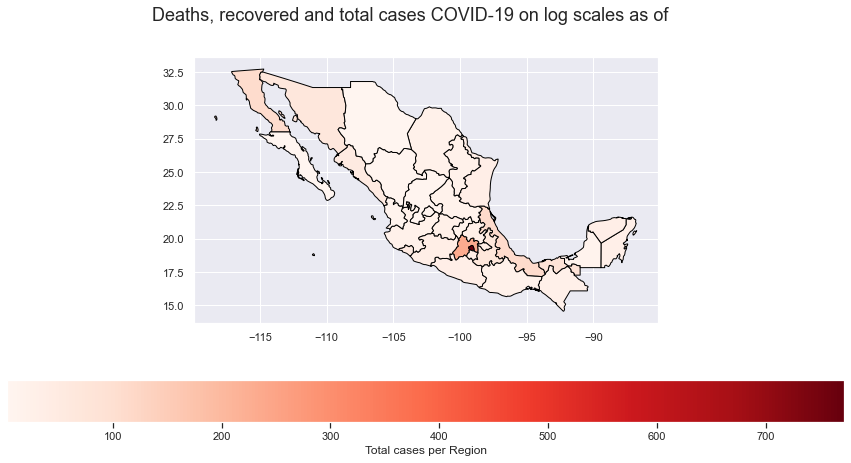

In [117]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle('Deaths, recovered and total cases COVID-19 on log scales as of ', fontsize=18)


df_test.plot(column='RESULTADO', ax=ax, legend=True, legend_kwds={'label': "Total cases per Region", 'orientation': "horizontal"},
                  edgecolor='black', cmap='Reds')
df_test.plot(column='DEF', ax=ax, legend=True, legend_kwds={'label': "Total deaths per Region", 'orientation': "horizontal"},
                  edgecolor='black', cmap='Greys')
plt.show()